# Tutorial for bulk Monte Carlo simulations in the structural-color package

Copyright 2016, Vinothan N. Manoharan, Victoria Hwang, Annie Stephenson

This file is part of the structural-color python package.

This package is free software: you can redistribute it and/or modify it under the terms of the GNU General Public License as published by the Free Software Foundation, either version 3 of the License, or (at your option) any later version.

This package is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU General Public License for more details.

You should have received a copy of the GNU General Public License along with this package. If not, see http://www.gnu.org/licenses/.

## Introduction to bulk Monte Carlo simulations

Monte Carlo simulations in the structural-color package can be run on multiple levels for specific types of samples. For example, we can first use Monte Carlo to calculate the reflectance of a particle assembly in a spherical geometry, and then use a second Monte Carlo simulation to calculate the reflectance if we took many of those spheres and packed them into a film. 

Future versions of this code may be able to handle layers of films or spheres of films, but the current version is best equipped to handle spheres in spheres, and trying other sample configurations may result in errors or incorrect results. 

We call this module bulk_montecarlo because we want to distinguish it from the lower level structures inside it. We are looking at bulk films made up of spheres wich contain particle packings (the particles also happen to be spheres).

The idea behind the bulk Monte Carlo simulations is simple. We first perform a Monte Carlo simulation of trajectories scattering through a sphere and calculate the reflectance and transmittance. We then use these values along with other scattering information obtained from the simulation to calculate a simulated total scattering cross section for the sphere. This gives us everything we need to do a second Monte Carlo simulation, treating the spheres (that is, the larger spheres containing the packings) as we normally would the particles (the spherical particles we assume in a normal Monte Carlo simulation). We can then calculate a reflectance from such a bulk film.

Below is an example that calculates a reflectance spectrum from a bulk film, step-by-step. 

## Loading and using the package and module

You'll need the following imports

In [1]:
%matplotlib inline
import numpy as np
import structcol as sc
import structcol.refractive_index as ri
from structcol import montecarlo as mc
from structcol import phase_func_sphere as pfs
import matplotlib.pyplot as plt
import seaborn as sns
import os

## Start by running Monte Carlo code for a single sphere
This is essentially the same as running MC for a sphere as described in montecarlo_tutorial.ipynb, only we return a few extra parameters from calc_refl_trans() and use them to calculate the phase function, scattering coefficient, and absorption coefficient for the bulk Monte Carlo simulation.

#### Set parameters
We have to set a few extra parameters for the bulk simulation

In [2]:
# Properties of source
wavelengths = sc.Quantity(np.arange(400., 801.,15),'nm') # wavelengths at which to calculate reflectance

# Geometric properties of sample
particle_radius = sc.Quantity('0.130 um')        # radius of the sphere particles 
volume_fraction_particles = sc.Quantity(0.6, '') # volume fraction of the particles in the sphere boundary
volume_fraction_bulk = sc.Quantity(0.55,'')      # volume fraction of the spheres in the bulk film
sphere_boundary_radius = sc.Quantity(5,'um')     # radius of the sphere boundary
bulk_thickness = sc.Quantity('20 um')            # thickness of the bulk film

# Refractive indices
n_particle = ri.n('vacuum', wavelengths)    # refractive index of particle
n_matrix = ri.n('polystyrene', wavelengths) + 2e-5*ri.n('vacuum', wavelengths)*1j # refractive index of matrix
n_matrix_bulk = ri.n('vacuum', wavelengths) # refractive index of the bulk matrix
n_medium = ri.n('vacuum', wavelengths)      # refractive index of medium outside the bulk sample. 

# Monte Carlo parameters
ntrajectories = 2000         # number of trajectories to run with a spherical boundary
nevents = 300                # number of scattering events for each trajectory in a spherical boundary
ntrajectories_bulk = 2000    # number of trajectories to run in the bulk film
nevents_bulk = 300           # number of events to run in the bulk film

# Properties that should not need to be changed
z_low = sc.Quantity('0.0 um') # sets trajectories starting point
sns.set_style('white')        # sets white plotting background

### Run Monte Carlo for sphere geometry 

The next code block is nearly identical to the code for running a sphere found in the montecarlo_tutorial.ipynb. The few differences are explained below

differences in mc:
1. In calc_refl_trans(), set the argument return_extra = True
<br>
We must set return_extra to True in order to return all of the parameters from reflection that are needed to calculate the scattering coefficient, absorption length, and phase function for the bulk
<br>
<br>
2. Pass n_matrix_bulk where you would normally pass n_medium
<br>
Since this sphere is embedded in a bulk film, the material outside the sphere is the matrix of the bulk, so where we would normally pass n_medium, we instead pass n_matrix_bulk
<br>
<br>
3. Run calc_scat_bulk() after calculating reflectance.
<br>
For each wavelength, after running calc_refl_trans(), we must run calc_scat_bulk() to get the phase function, scattering coeffient, and absorption coefficient for the bulk. These will be used in a later code block for the bulk Monte Carlo simulation 



In [3]:
# initialize quantities we want to save as a function of wavelength
reflectance_sphere = np.zeros(wavelengths.size)
mu_scat_bulk = sc.Quantity(np.zeros(wavelengths.size),'1/um')
mu_abs_bulk = sc.Quantity(np.zeros(wavelengths.size),'1/um')
p_bulk = np.zeros((wavelengths.size, 200))

# loop through wavelengths
for i in range(wavelengths.size):
    
    # print wavlengths to keep track of where we are in calculation
    print('wavelength: ' + str(wavelengths[i]))
    
    # caculate the effective index of the sample
    n_sample = ri.n_eff(n_particle[i], n_matrix[i], volume_fraction_particles)
    
    # Calculate the phase function and scattering and absorption coefficients from the single scattering model
    # (this absorption coefficient is of the scatterer, not of an absorber added to the system)
    p, mu_scat, mu_abs = mc.calc_scat(particle_radius, n_particle[i], n_sample,
                                      volume_fraction_particles, wavelengths[i])

    # Initialize the trajectories
    r0, k0, W0 = mc.initialize_sphere(nevents, ntrajectories, n_matrix_bulk[i], n_sample, sphere_boundary_radius)
    r0 = sc.Quantity(r0, 'um')
    k0 = sc.Quantity(k0, '')
    W0 = sc.Quantity(W0, '')

    # Create trajectories object
    trajectories = mc.Trajectory(r0, k0, W0)

    # Generate a matrix of all the randomly sampled angles first 
    sintheta, costheta, sinphi, cosphi, _, _ = mc.sample_angles(nevents, ntrajectories, p)

    # Create step size distribution
    step = mc.sample_step(nevents, ntrajectories, mu_abs, mu_scat)

    # Run photons
    trajectories.absorb(mu_abs, step)                         
    trajectories.scatter(sintheta, costheta, sinphi, cosphi)         
    trajectories.move(step)

    # Calculate reflection and transmition 
    (refl_indices, 
     trans_indices, 
     k1_refl, k1_trans, 
     norm_refl, norm_trans,
     refl_per_traj, trans_per_traj,
     reflectance_sphere[i], 
     transmittance_sphere)\
             = mc.calc_refl_trans_sphere(trajectories, n_matrix_bulk[i], n_sample, 
                                         sphere_boundary_radius, 
                                         p, mu_abs, mu_scat,  
                                         run_tir = False, 
                                         return_extra = True)
        
    ### Calculate phase function and lscat ###
    # use output of calc_refl_trans to calculate phase function, mu_scat, and mu_abs for the bulk
    p_bulk[i,:], mu_scat_bulk[i], mu_abs_bulk[i] = pfs.calc_scat_bulk(refl_per_traj, trans_per_traj, 
                                                                     trans_indices, 
                                                                     norm_refl, norm_trans, 
                                                                     volume_fraction_bulk, 
                                                                     sphere_boundary_radius,
                                                                     plot=False, phi_dependent=False)
    

wavelength: 400.0 nanometer


/home/stephenson/anaconda3/lib/python3.5/site-packages/Pint-0.7.2-py3.5.egg/pint/quantity.py:912: RuntimeWarning: invalid value encountered in greater
/home/stephenson/Repositories/structural-color/structcol/montecarlo.py:360: RuntimeWarning: invalid value encountered in double_scalars
  return((x-x0)/(x1-x0)-(y-y0)/(y1-y0), (z-z0)/(z1-z0)-(y-y0)/(y1-y0), x**2 + y**2 + z**2-radius**2 )
/home/stephenson/Repositories/structural-color/structcol/montecarlo.py:360: RuntimeWarning: divide by zero encountered in double_scalars
  return((x-x0)/(x1-x0)-(y-y0)/(y1-y0), (z-z0)/(z1-z0)-(y-y0)/(y1-y0), x**2 + y**2 + z**2-radius**2 )
/home/stephenson/Repositories/structural-color/structcol/montecarlo.py:606: RuntimeWarning: invalid value encountered in true_divide
  k1 = k1/mag
/home/stephenson/Repositories/structural-color/structcol/montecarlo.py:628: RuntimeWarning: invalid value encountered in true_divide
  dot_z = np.nan_to_num(abs(select_z1-select_z0)/mag)


wavelength: 415.0 nanometer
wavelength: 430.0 nanometer
wavelength: 445.0 nanometer
wavelength: 460.0 nanometer
wavelength: 475.0 nanometer
wavelength: 490.0 nanometer
wavelength: 505.0 nanometer
wavelength: 520.0 nanometer
wavelength: 535.0 nanometer
wavelength: 550.0 nanometer
wavelength: 565.0 nanometer
wavelength: 580.0 nanometer
wavelength: 595.0 nanometer
wavelength: 610.0 nanometer
wavelength: 625.0 nanometer
wavelength: 640.0 nanometer
wavelength: 655.0 nanometer
wavelength: 670.0 nanometer
wavelength: 685.0 nanometer
wavelength: 700.0 nanometer
wavelength: 715.0 nanometer
wavelength: 730.0 nanometer
wavelength: 745.0 nanometer
wavelength: 760.0 nanometer
wavelength: 775.0 nanometer
wavelength: 790.0 nanometer


#### Plot results

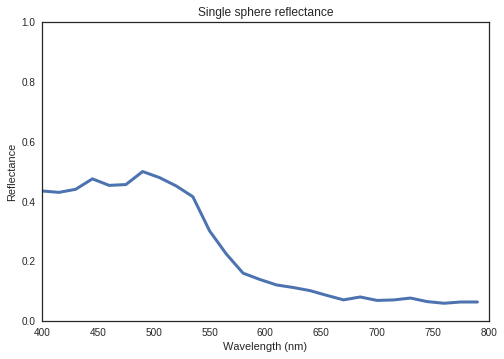

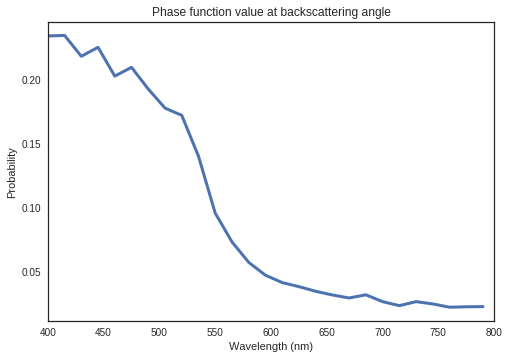

In [4]:
plt.figure()
plt.plot(wavelengths, reflectance_sphere, linewidth = 3)
plt.ylim([0,1])
plt.xlim([400,800])
plt.xlabel('Wavelength (nm)')
plt.ylabel('Reflectance')
plt.title('Single sphere reflectance')

plt.figure()
plt.plot(wavelengths, p_bulk[:,100], linewidth = 3)
plt.xlim([400,800])
plt.xlabel('Wavelength (nm)')
plt.ylabel('Probability')
plt.title('Phase function value at backscattering angle')

The first plot shows us the reflectance of a single sphere, which should give us a qualitative guide for the features we expect to see in the bulk film reflectance. 

The second plot shows the value of the bulk phase function at the backscattering angle, as a function of wavelength. This plot tells us the probability of backscattering at any given wavelength. It should not match up perfectly with the single sphere reflectance, as the reflectance includes scattering from the entire reflection hemisphere, but it should have some qualitatively similar features. 

### Calculate reflectance for bulk film of structurally colored microspheres
The following code block is nearly identical to the code for running the Monte Carlo simulation for a film. 

Notes:
- We replace many quantities with their bulk counterpart, e.g. nevents_bulk instead of nevents.
- We use n_matrix_bulk here instead of an n_sample calculated from effective medium theory because usually, the spheres in a bulk film are significantly larger than the wavelength of light, so we can simply use the matrix rather than an effective medium. However, if you run the simulation with smaller spheres (close to the wavelength of light), you may want to change n_matrix_bulk to n_sample calculate from effective medium theory. 


In [5]:
# initialize some quantities we want to save as a function of wavelength
reflectance_bulk = np.zeros(wavelengths.size)

# loop through wavelengths
for i in range(wavelengths.size):
    
    # print the wavelength keep track of where we are in calculation 
    print('wavelength: ' + str(wavelengths[i]))

    # Initialize the trajectories
    r0, k0, W0 = mc.initialize(nevents_bulk, ntrajectories_bulk, n_medium[i], n_matrix_bulk[i])
    r0 = sc.Quantity(r0, 'um')
    W0 = sc.Quantity(W0, '')
    k0 = sc.Quantity(k0, '')

    # Sample angles
    sintheta, costheta, sinphi, cosphi, _, _ = mc.sample_angles(nevents_bulk, ntrajectories_bulk, 
                                                                p_bulk[i,:])
    # Calculate step size
    step = mc.sample_step(nevents_bulk, ntrajectories_bulk, mu_scat_bulk[i], mu_scat_bulk[i])
    
    # Create trajectories object
    trajectories = mc.Trajectory(r0, k0, W0)

    # Run photons
    trajectories.absorb(mu_abs_bulk[i], step)  
    trajectories.scatter(sintheta, costheta, sinphi, cosphi)         
    trajectories.move(step)

    # calculate reflectance
    reflectance_bulk[i], transmittance = mc.calc_refl_trans(trajectories, z_low, bulk_thickness, 
                                                               n_medium[i], n_matrix_bulk[i])

wavelength: 400.0 nanometer
wavelength: 415.0 nanometer
wavelength: 430.0 nanometer
wavelength: 445.0 nanometer
wavelength: 460.0 nanometer
wavelength: 475.0 nanometer
wavelength: 490.0 nanometer
wavelength: 505.0 nanometer
wavelength: 520.0 nanometer
wavelength: 535.0 nanometer
wavelength: 550.0 nanometer
wavelength: 565.0 nanometer
wavelength: 580.0 nanometer
wavelength: 595.0 nanometer
wavelength: 610.0 nanometer
wavelength: 625.0 nanometer
wavelength: 640.0 nanometer
wavelength: 655.0 nanometer
wavelength: 670.0 nanometer
wavelength: 685.0 nanometer
wavelength: 700.0 nanometer
wavelength: 715.0 nanometer
wavelength: 730.0 nanometer
wavelength: 745.0 nanometer
wavelength: 760.0 nanometer
wavelength: 775.0 nanometer
wavelength: 790.0 nanometer


#### Plot results

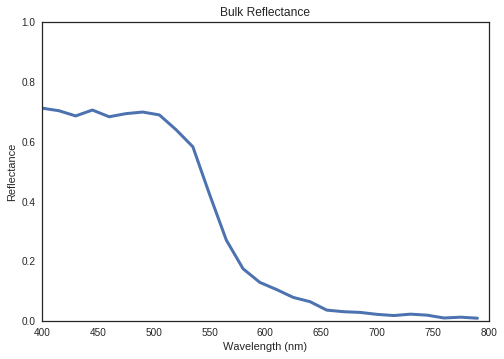

In [6]:
plt.figure()
plt.plot(wavelengths, reflectance_bulk, linewidth = 3)
plt.ylim([0,1])
plt.xlim([400,800])
plt.xlabel('Wavelength (nm)')
plt.ylabel('Reflectance')
plt.title('Bulk Reflectance')

This plot of reflectance versus wavelength shows that the bulk reflectance qualitatively behaves similarly to a single sphere